## Configs

### Imports

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import sys

sys.version

'3.10.6 (main, May 29 2023, 11:10:38) [GCC 11.3.0]'

### Vars

In [24]:
# Dictionary with labels to charts
labels_dict = {
    'fecha': 'Date', 
    'genero_persona_en_situacion_de_violencia': 'Gender of person in situation of violence',
    'edad_persona_en_situacion_de_violencia': 'Age of person in situation of violence',
    'tipo_de_violencia_fisica_pct': 'Violencia física',
    'tipo_de_violencia_psicologica_pct': 'Violencia psicológica', 
    'tipo_de_violencia_sexual_pct': 'Violencia sexual',
    'tipo_de_violencia_economica_y_patrimonial_pct': 'Violencia económica y patrimonial',
    'tipo_de_violencia_simbolica_pct': 'Violencia simbólica', 
    'tipo_de_violencia_domestica_pct': 'Violencia doméstica',
    'modalidad_de_violencia_institucional_pct': 'Violencia institucional',
    'modalidad_de_violencia_laboral_pct': 'Violencia laboral',
    'modalidad_violencia_contra_libertad_reproductiva_pct': 'Violencia contra la libertad reproductiva',
    'modalidad_de_violencia_obstetrica_pct': 'Violencia obstétrica',
    'modalidad_de_violencia_mediatica_pct': 'Violencia mediática',
    'modalidad_de_violencia_otras_pct': 'Otras violencias',
    'tipo_de_violencia_fisica': 'Violencia física',
    'tipo_de_violencia_psicologica': 'Violencia psicológica', 
    'tipo_de_violencia_sexual': 'Violencia sexual',
    'tipo_de_violencia_economica_y_patrimonial': 'Violencia económica y patrimonial',
    'tipo_de_violencia_simbolica': 'Violencia simbólica', 
    'tipo_de_violencia_domestica': 'Violencia doméstica',
    'modalidad_de_violencia_institucional': 'Violencia institucional',
    'modalidad_de_violencia_laboral': 'Violencia laboral',
    'modalidad_violencia_contra_libertad_reproductiva': 'Violencia contra la libertad reproductiva',
    'modalidad_de_violencia_obstetrica': 'Violencia obstétrica',
    'modalidad_de_violencia_mediatica': 'Violencia mediática',
    'modalidad_de_violencia_otras': 'Otras violencias'
}

# Plotly templates
# SEABORNs = ["plotly", "plotly_white", "plotly_dark", "ggplot2", "seaborn", "simple_white", "none"]

SEABORN = "seaborn"

## Load and clean data

### Load from datasource

In [25]:
years = [2020, 2021, 2022, 2023]
data_dict = {}

for year in years:
    data_dict[year] = pd.read_csv(f'./data/linea144-{year}.csv', parse_dates=['fecha'])

data = pd.concat(data_dict, ignore_index=True)

# Excluding last column with no data
data = data.iloc[:,:-1]

assert data.shape == (84861, 19)
assert data.fecha.dtype == 'datetime64[ns]', "'fecha' must be a datetime64 type"

### Filling missing values (categorical) 

**Summary from the article**

So the first step is to see if your data has missing values. If your data has missing values, you need to check the distribution of each numerical variable (with missing values). If the values in the numerical variables are missing, use the Mean value if the variable is in a normal distribution. Otherwise, choose Median. And if the variable is categorical or discrete, you can select mode. So you need to choose a different measure for each variable. I hope you liked this article on how to fill in missing values in your data. Feel free to ask valuable questions in the comments section below. [More...](https://thecleverprogrammer.com/2023/03/14/heres-how-to-fill-in-missing-values-in-a-dataset/)

In [26]:
# Filling nan rows with mode
def fill_with_mode_the_nan_values(field):

    try:
      # n records NaN to theis field 
      fields_nan = data[field].isna().sum()
            
      if fields_nan > 0:
          # filling using the mode, like shown in link above
          field_mode = data[field].mode()[0]

          data[field].fillna(field_mode, inplace=True)
      return field, fields_nan
    except Exception as e:
       return e
       
fields = ['prov_residencia_persona_en_situacion_violencia', 'genero_persona_en_situacion_de_violencia', \
          'pais_nacimiento_persona_en_situacion_de_violencia', 'vinculo_con_la_persona_agresora', \
            'genero_de_la_persona_agresora']

[fill_with_mode_the_nan_values(field) for field in fields]

[('prov_residencia_persona_en_situacion_violencia', 1229),
 ('genero_persona_en_situacion_de_violencia', 1776),
 ('pais_nacimiento_persona_en_situacion_de_violencia', 28706),
 ('vinculo_con_la_persona_agresora', 3192),
 ('genero_de_la_persona_agresora', 8737)]

### Filling numeric values (edad_persona_en_situacion_de_violencia) using the median
* **Mean**, when we have a normal distribution
* **Median**, otherwise

Kurtosis: 1.315091416195283
There are/was 16402 missing values to field "edad_persona_en_situacion_de_violencia"


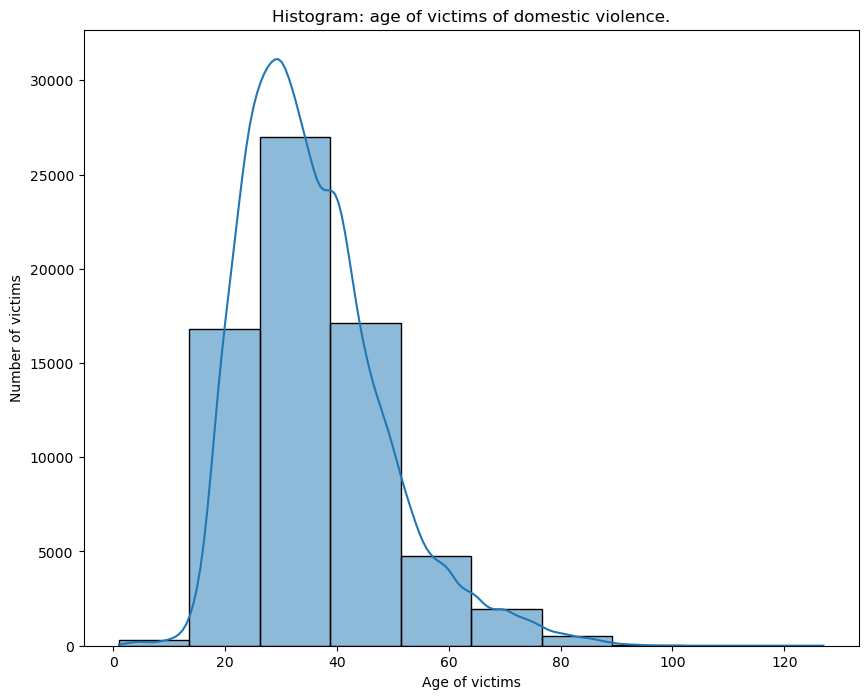

In [27]:
# Histogram: distribution ins't normal

# Calculate kurtosis
print(f'Kurtosis: {data.edad_persona_en_situacion_de_violencia.kurtosis()}')

# Count of missing values
print(f'There are/was {data.edad_persona_en_situacion_de_violencia.isna().sum()} missing values to field "edad_persona_en_situacion_de_violencia"')

plt.figure(figsize=(10, 8))
f = sns.histplot(data['edad_persona_en_situacion_de_violencia'], bins=10, kde=True)
f.set_title('Histogram: age of victims of domestic violence.')
f.set_xlabel("Age of victims")
f.set_ylabel("Number of victims")
plt.show()

# Calculate the median
age_median = data.edad_persona_en_situacion_de_violencia.median()

# Filling data with the mean
data.fillna(age_median, inplace=True)


### Updating types and modalities whose values are boolean

In [28]:


# 1. Define wich fields will be processed 
boolean_fields = ['tipo_de_violencia_fisica', 'tipo_de_violencia_psicologica', 'tipo_de_violencia_sexual', \
                    'tipo_de_violencia_economica_y_patrimonial', 'tipo_de_violencia_simbolica', 'tipo_de_violencia_domestica',
                    'modalidad_de_violencia_institucional', 'modalidad_de_violencia_laboral', \
                    'modalidad_violencia_contra_libertad_reproductiva', 'modalidad_de_violencia_obstetrica', \
                    'modalidad_de_violencia_mediatica', 'modalidad_de_violencia_otras']


# 2. View and confirmation that they are boolean
def fields_view_validation(field):
    print(f"Types for field '{field}': {data[field].unique()}")

# 3. Show
[fields_view_validation(field) for field in boolean_fields]

# 4. Cast to boolean 
mapping = {'Si': True, 'SI': True, 'No': False, 'NO': False} 
for field in boolean_fields:
    data[field] = data[field].map(mapping)

# 5. Unify "duplicate" province
data['prov_residencia_persona_en_situacion_violencia'] = data['prov_residencia_persona_en_situacion_violencia'] \
    .apply(lambda x : 'Santiago Del Estero' if x == 'Santiago del Estero' else x)

data['prov_residencia_persona_en_situacion_violencia'] = data['prov_residencia_persona_en_situacion_violencia'] \
    .apply(lambda x : 'Córdoba' if x == 'Cordoba' else x)



Types for field 'tipo_de_violencia_fisica': ['Si' 'No']
Types for field 'tipo_de_violencia_psicologica': ['Si' 'No']
Types for field 'tipo_de_violencia_sexual': ['No' 'Si' 'SI']
Types for field 'tipo_de_violencia_economica_y_patrimonial': ['No' 'Si']
Types for field 'tipo_de_violencia_simbolica': ['No' 'Si' 'SI']
Types for field 'tipo_de_violencia_domestica': ['Si' 'No']
Types for field 'modalidad_de_violencia_institucional': ['No' 'Si' 'SI']
Types for field 'modalidad_de_violencia_laboral': ['No' 'Si' 'SI']
Types for field 'modalidad_violencia_contra_libertad_reproductiva': ['No' 'Si' 'SI']
Types for field 'modalidad_de_violencia_obstetrica': ['No' 'Si' 'SI']
Types for field 'modalidad_de_violencia_mediatica': ['No' 'Si']
Types for field 'modalidad_de_violencia_otras': ['No' 'Si']


## Explore

### 01 How big is the dataset? How many rows (records) and columns (attributes) are there?


In [29]:
print("Datasource with {} lines (records) and {} columns (attributes)".format(data.shape[0], data.shape[1]))

Datasource with 84861 lines (records) and 19 columns (attributes)


### 02 What are the data types of each column (attribute)? For example, victim's gender can be categorical, age is numerical, city is categorical, etc. 

The data has been processed.

* Types yes or no, was cleaned and cast to boolean
* date (first column) was cast to datetime64
* age was float and stay
* other values stayed string (object)

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84861 entries, 0 to 84860
Data columns (total 19 columns):
 #   Column                                             Non-Null Count  Dtype         
---  ------                                             --------------  -----         
 0   fecha                                              84861 non-null  datetime64[ns]
 1   prov_residencia_persona_en_situacion_violencia     84861 non-null  object        
 2   genero_persona_en_situacion_de_violencia           84861 non-null  object        
 3   edad_persona_en_situacion_de_violencia             84861 non-null  float64       
 4   pais_nacimiento_persona_en_situacion_de_violencia  84861 non-null  object        
 5   tipo_de_violencia_fisica                           84861 non-null  bool          
 6   tipo_de_violencia_psicologica                      84861 non-null  bool          
 7   tipo_de_violencia_sexual                           84861 non-null  bool          
 8   tipo_de_violenci

### 03 What is the gender distribution of victims in the dataset? Are there more female, male or other gender victims? Can there be cases of not informed?

In the first chart, we can see that the overwhelming majority of victims of violence are women.

In the second chart, we use a logarithmic scale, in this way - although we may lose the dimension of the difference, we get an idea of the scales of the other genres present in the dataset.

In [31]:
by_gender = data.groupby('genero_persona_en_situacion_de_violencia').size().reset_index()
by_gender.columns = ['genero', 'size']

fig = px.treemap(by_gender, \
                 path=['genero'], \
                 values='size', \
                 title="Gender distribution", template=SEABORN)

fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))

fig.show()

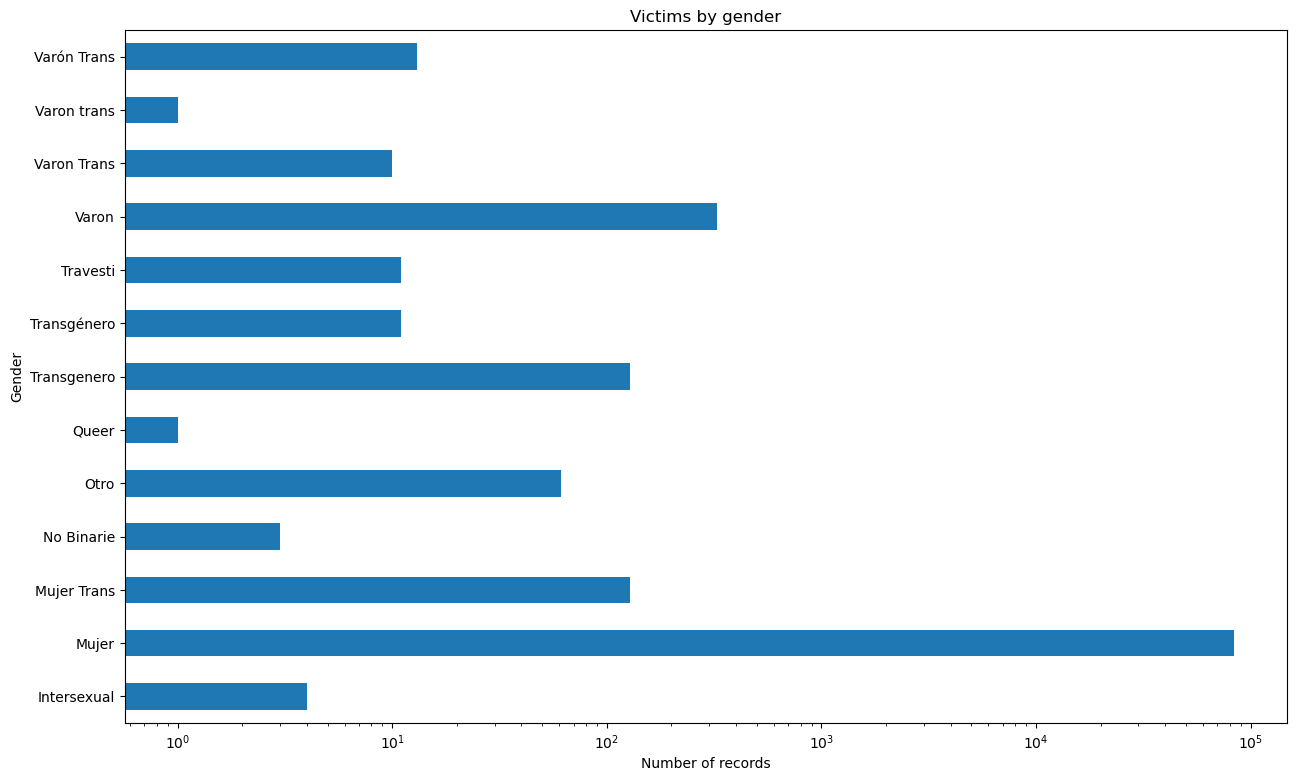

In [32]:
plt.figure(figsize=(15,9))
ax = data.groupby('genero_persona_en_situacion_de_violencia').size() \
    .plot(kind='barh', title='Victims by gender', logx=True)

ax.set_ylabel('Gender')
ax.set_xlabel('Number of records')

plt.show()

### 04 What is the predominant age group of victims? Are there outliers or unusual age values?

Victims are mainly between 20 and 40 years old.

The number of women's records is significantly higher, which is why we possibly find more outliers due to errors (there is a 127-year-old record)

In [33]:
fig = px.box(data, y='edad_persona_en_situacion_de_violencia', x='genero_persona_en_situacion_de_violencia', \
            title='Distribution and outliers of age of persons in violent situation', \
            color='genero_persona_en_situacion_de_violencia', \
            labels=labels_dict)
fig.show()

### 05 What are the most common types of violence reported? It is possible to make a count or bar graph to visualize the distribution of types of violence.

In [34]:
# Select unique genders
genders = list(data.genero_persona_en_situacion_de_violencia.unique())

# Get types of violences (features)
types_of_violence = ['tipo_de_violencia_fisica', 'tipo_de_violencia_psicologica',
       'tipo_de_violencia_sexual', 'tipo_de_violencia_economica_y_patrimonial',
       'tipo_de_violencia_simbolica', 'tipo_de_violencia_domestica',
       'modalidad_de_violencia_institucional',
       'modalidad_de_violencia_laboral',
       'modalidad_violencia_contra_libertad_reproductiva',
       'modalidad_de_violencia_obstetrica', 'modalidad_de_violencia_mediatica',
       'modalidad_de_violencia_otras']

# Iterates types of violence to fill a new dataframe when the type of violence occurs (is true)
# _col: the feature to 'groupby' (string)
# _indexes: the columns to new complex dataframe (axis x)
# _features: the rows to complex dataframe (axis y)
def get_complex_dataframe(_col, _indexes, _features): 
    # Create new dataframe
    df_result = pd.DataFrame(columns=_indexes)

    for feat in _features:
        row = data[data[feat] == True].groupby(_col).size()
        row_dict = {}
        for feature, _count in zip(row.index, row.values):
            row_dict[feature] = int(_count)
        df_result.loc[feat] = row_dict
        df_result.fillna(0, inplace=True)

    return df_result

df_types_of_violence = get_complex_dataframe('genero_persona_en_situacion_de_violencia', \
                                             genders,
                                             types_of_violence)


# Process "varon trans" feature, thats repeated with 3 different names
df_types_of_violence['Varon Trans'] = df_types_of_violence.apply(lambda x : x['Varon Trans'] + x['Varon trans'] + x['Varón Trans'], axis=1)
df_types_of_violence.drop(['Varon trans', 'Varón Trans'], axis=1, inplace=True)

# Sum all genders data
df_types_of_violence['Todos_los_generos'] = df_types_of_violence.apply(lambda row : sum(row.values), axis=1)

# Print
print('Number os cases by violence type and gender')
df_types_of_violence

Number os cases by violence type and gender


Mujer  Varon  Mujer Trans  \
tipo_de_violencia_fisica                          55646  205.0         58.0   
tipo_de_violencia_psicologica                     79874  302.0        106.0   
tipo_de_violencia_sexual                          11445   51.0         23.0   
tipo_de_violencia_economica_y_patrimonial         33740  117.0         20.0   
tipo_de_violencia_simbolica                       28654   86.0         56.0   
tipo_de_violencia_domestica                       76619  278.0         74.0   
modalidad_de_violencia_institucional               1195   10.0         11.0   
modalidad_de_violencia_laboral                     1148   12.0          7.0   
modalidad_violencia_contra_libertad_reproductiva    380    0.0          0.0   
modalidad_de_violencia_obstetrica                    79    0.0          0.0   
modalidad_de_violencia_mediatica                     47    0.0          1.0   
modalidad_de_violencia_otras                       1943    8.0         15.0   

                                                  Transgenero  Otro  \
tipo_de_violencia_fisica                                 60.0  30.0   
tipo_de_violencia_psicologica                           114.0  56.0   
tipo_de_violencia_sexual                                 32.0  13.0   
tipo_de_violencia_economica_y_patrimonial                29.0  16.0   
tipo_de_violencia_simbolica                              40.0  36.0   
tipo_de_violencia_domestica                              69.0  42.0   
modalidad_de_violencia_institucional                     20.0   8.0   
modalidad_de_violencia_laboral                           10.0   3.0   
modalidad_violencia_contra_libertad_reproductiva          0.0   1.0   
modalidad_de_violencia_obstetrica                         0.0   0.0   
modalidad_de_violencia_mediatica                          2.0   0.0   
modalidad_de_violencia_otras                              0.0   3.0   

                                                  Intersexual  Travesti  \
tipo_de_violencia_fisica                                  3.0       6.0   
tipo_de_violencia_psicologica                             4.0      10.0   
tipo_de_violencia_sexual                                  0.0       1.0   
tipo_de_violencia_economica_y_patrimonial                 2.0       2.0   
tipo_de_violencia_simbolica                               0.0       3.0   
tipo_de_violencia_domestica                               4.0       3.0   
modalidad_de_violencia_institucional                      0.0       4.0   
modalidad_de_violencia_laboral                            0.0       0.0   
modalidad_violencia_contra_libertad_reproductiva          0.0       0.0   
modalidad_de_violencia_obstetrica                         0.0       0.0   
modalidad_de_violencia_mediatica                          0.0       0.0   
modalidad_de_violencia_otras                              0.0       2.0   

                                                  Queer  Varon Trans  \
tipo_de_violencia_fisica                            1.0         13.0   
tipo_de_violencia_psicologica                       1.0         24.0   
tipo_de_violencia_sexual                            0.0          2.0   
tipo_de_violencia_economica_y_patrimonial           0.0          5.0   
tipo_de_violencia_simbolica                         1.0         17.0   
tipo_de_violencia_domestica                         1.0         17.0   
modalidad_de_violencia_institucional                0.0          3.0   
modalidad_de_violencia_laboral                      0.0          2.0   
modalidad_violencia_contra_libertad_reproductiva    0.0          0.0   
modalidad_de_violencia_obstetrica                   0.0          0.0   
modalidad_de_violencia_mediatica                    0.0          0.0   
modalidad_de_violencia_otras                        0.0          2.0   

                                                  No Binarie  Transgénero  \
tipo_de_violencia_fisica                                 2.0         11.0   
tipo_de_violencia_psicologica  

In [35]:
fig = px.bar(x=df_types_of_violence.index, y=df_types_of_violence['Todos_los_generos'], \
            title="Types of violence (all genders)", template=SEABORN)

fig.update_layout(
    xaxis_title='Type of violence',
    yaxis_title='Number of cases'
)

fig.show()

In [36]:
# Calculate PCTs

# Get transposed
df_types_of_violence_by_pct = df_types_of_violence.T

# Iterate to calculate PCTs of all features
for col in df_types_of_violence_by_pct.columns:
    new_col = '{}_pct'.format(col)
    df_types_of_violence_by_pct[new_col] = df_types_of_violence_by_pct.apply(lambda row : (row[col] / sum(row.iloc[:12])*100), axis=1)
    df_types_of_violence_by_pct.drop(col, axis=1, inplace=True)

# Results
df_types_of_violence_by_pct.reset_index(inplace=True, names=['genero'])

df_types_of_violence_by_pct


genero  tipo_de_violencia_fisica_pct  \
0               Mujer                     19.137463   
1               Varon                     19.176801   
2         Mujer Trans                     15.633423   
3         Transgenero                     15.957447   
4                Otro                     14.423077   
5         Intersexual                     23.076923   
6            Travesti                     19.354839   
7               Queer                     25.000000   
8         Varon Trans                     15.294118   
9          No Binarie                     20.000000   
10        Transgénero                     28.947368   
11  Todos_los_generos                     19.126205   

    tipo_de_violencia_psicologica_pct  tipo_de_violencia_sexual_pct  \
0                           33.968246                      7.369460   
1                           34.194739                      8.287676   
2                           32.254784                      9.023564   
3                           34.341751                     12.683354   
4                           29.102538                      7.853769   
5                           12.093023                      0.000000   
6                           22.545455                      1.757460   
7                            3.571429                      0.000000   
8                           27.493261                      2.202949   
9                           10.714286                      0.000000   
10                          19.661336                      6.191116   
11                          33.974214                      7.394172   

    tipo_de_violencia_economica_y_patrimonial_pct  \
0                                       23.452465   
1                                       20.430999   
2                                        8.301794   
3                                       12.447284   
4                                        9.976345   
5                                        4.857913   
6                                        3.468744   
7                                        0.000000   
8                                        5.495090   
9                                        2.800000   
10                                       4.491030   
11                                      23.415641   

    tipo_de_violencia_simbolica_pct  tipo_de_violencia_domestica_pct  \
0                         26.013871                        93.986893   
1                         18.063803                        68.111543   
2                         24.431364                        37.440880   
3                         18.481740                        35.400668   
4                         23.322749                        29.644587   
5                          0.000000                         9.085157   
6                          5.073867                         4.901932   
7                          3.271028                         3.044839   
8                         18.582196                        18.266290   
9                          2.665651                         7.656980   
10                         2.928650                         7.223398   
11                        26.029405                        93.879036   

    modalidad_de_violencia_institucional_pct  \
0                                  23.919478   
1                                   5.043740   
2                                   6.828659   
3                                  12.398315   
4                                   6.186058   
5                                   0.000000   
6                                   6.338914   
7                                   0.000000   
8                                   3.180193   
9                                   0.000000   
10                                  2.799438   
11                                 24.463966   

    modalidad_de_violencia_laboral_pct  \
0                            30.014266   
1                             6.207668 

In [37]:
# Plot by gender
data_chart = []
genders = df_types_of_violence_by_pct.genero.values[:-1]

for _type in df_types_of_violence_by_pct.columns[1:]:
    data_chart.append(
        go.Bar(name=labels_dict[_type], x=genders, y=df_types_of_violence_by_pct[_type].values)
    )

fig = go.Figure(data=data_chart)
fig.update_layout(barmode='group', title='Type of violence (by gender)', template=SEABORN)
fig.show()

### 06 Is there any correlation between the gender of the victim and the type of violence reported? For example, are certain types of violence more prevalent in victims of a certain gender?

In [38]:
# Setting gender to index
data_heatmap = df_types_of_violence_by_pct.set_index('genero')

# Building chart
fig = px.imshow(data_heatmap.iloc[0:-1,:], \
                text_auto=True, \
                labels=labels_dict, 
                title="Percentage incidence between gender and violence type",
                aspect="auto")
fig.show()

### 07 What are the cities or regions with the highest number of reported cases of domestic violence?

* Chart 01. Provinces with more number of calls (*)
* Chart 01. Types of violence by provinces.

(*) "Ciudad Autónoma de Buenos Aires" isn't a Province, but the capital of the country. 

In [39]:
calls_by_province = data.groupby('prov_residencia_persona_en_situacion_violencia').size()

fig = px.bar(x=calls_by_province.index, y=calls_by_province.values, template=SEABORN)
fig.update_layout(barmode='stack',
                  title='Number of calls by province',
                  yaxis_title='Number of Calls', 
                  xaxis_title='Province', 
                  xaxis={'categoryorder': 'total descending'})
fig.show()

In [40]:
type_violence_by_province = get_complex_dataframe('prov_residencia_persona_en_situacion_violencia', 
                      list(data.prov_residencia_persona_en_situacion_violencia.unique()), 
                      types_of_violence)

for province in type_violence_by_province.T.iterrows():
    # filtering values more than zero
    values = pd.DataFrame([val for val in province[1].items() if val[1] > 0.1], columns=['_type', '_value']) 

    fig = px.bar(x=values._type, y=values._value,
                 template=SEABORN, 
                 title='Types of violence by province [{}]'.format(province[0]))
    
    fig.update_layout(barmode='stack',
                  yaxis_title='Number of cases', 
                  xaxis_title='Type of violence', 
                  xaxis={'categoryorder': 'total descending'})
    
    fig.show()

### 08 Is it possible to identify any seasonality in the data? Any patterns or trends over time?

#### Time Series Analyses

**Adding time dimensions** (_month, year, monthly_)


In [41]:
data['month'] = data.fecha.map(lambda x : x.month)
data['year'] = data.fecha.map(lambda x : x.year)
data['monthly'] = data.fecha.map(lambda x : "{}-{}".format(x.year, str(x.month).zfill(2)))

data[['fecha', 'month', 'year', 'monthly']].sample(5).sort_values(by='fecha')

fecha  month  year  monthly
19867 2020-08-22      8  2020  2020-08
20131 2020-08-25      8  2020  2020-08
45401 2021-08-16      8  2021  2021-08
57693 2022-02-10      2  2022  2022-02
67783 2022-07-07      7  2022  2022-07

#### Cases by month

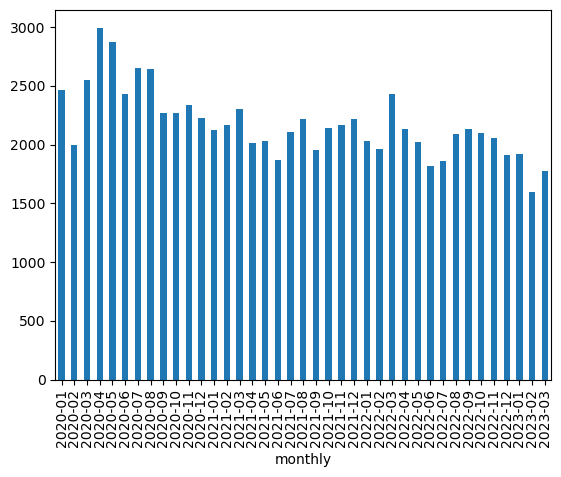

In [42]:
monthly = data.groupby('monthly').size().plot(kind='bar')

In [43]:
periods = data['monthly'].unique()
types_of_violence_by_period = get_complex_dataframe('monthly', periods, types_of_violence)

In [91]:
for province in types_of_violence_by_period.iterrows():
    # filtering values more than zero
    values = pd.DataFrame([val for val in province[1].items()], columns=['_type', '_value']) 

    fig = px.line(x=values._type, y=values._value,
                 template=SEABORN, 
                 title='{} along periods'.format(labels_dict[province[0]]))
    
    fig.update_layout(barmode='stack',
                  yaxis_title='Number of cases', 
                  xaxis_title='Time')
    
    fig.show()



### 09 What are the most common types of violence in each age group? It is possible to create age groups to facilitate the analysis.

#### Creating age groups

In [100]:
# Cutting dataset by age
_age = 'edad_persona_en_situacion_de_violencia'
_, edges = np.histogram(data[_age], bins=7) 

data['age_group'] = pd.cut(data[_age], bins=edges, 
        labels=['0-19', '20-37', '38-55', '56-73', '74-91', '92-109', '110-127'],
        include_lowest=True)


#### Plotting calls by age groups

In [79]:
calls_by_age_group = data.groupby('age_group').size()
fig = px.bar(x=calls_by_age_group.index, y=calls_by_age_group.values,
             template=SEABORN, 
             title="Calls by age group")

fig.update_layout(
    xaxis_title='Age Group',
    yaxis_title='Number of calls'
)

fig.show()

#### Plotting types of violence by age groups

In [101]:
types_of_violence_by_age_group = get_complex_dataframe('age_group', 
                                                       np.array(data.age_group.unique()), 
                                                       types_of_violence)

In [102]:
for group_age in types_of_violence_by_age_group.T.iterrows():
    # filtering values more than zero
    values = pd.DataFrame([val for val in group_age[1].items()], columns=['_type', '_value']) 

    fig = px.bar(x=values._type, y=values._value,
                 template=SEABORN, 
                 title='Types of violence in {} age group'.format(group_age[0]))
    
    fig.update_layout(barmode='stack',
                  yaxis_title='Number of cases', 
                  xaxis_title='Type of violence')
    
    fig.show()
